In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from matplotlib import gridspec
%matplotlib inline
from pathlib import Path
os.chdir(Path(os.getcwd()).absolute().parent)
from bayes_opt import BayesianOptimization

import os
import importlib
import bayesian_optimizer
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def posterior(gp, x):
    return gp.predict(x, return_std=True)

def plot_gp(gp, x, y, util):
    
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(bo.X)), fontdict={'size':30})
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, sigma = posterior(gp, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(gp.X_train_.flatten(), gp.y_train_, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility = util.utility(x, gp, gp.y_train_.max()) ##0???
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

### Target function

In [6]:
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

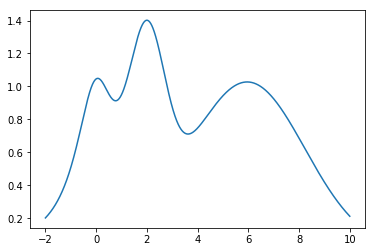

In [7]:
x = np.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)

plt.plot(x, y)

In [8]:
X_train = np.array([[0], [4]])
Y_train = np.array(list(map(target, list(X_train.reshape(1,-1).squeeze()))))
xi =1e-4
acq = 'ei'
n_iter=10
SEED = 6

## Original Implementation

In [9]:
gp_params = {"alpha": 1e-5, "n_restarts_optimizer": 25, "kernel": Matern(nu=2.5), "random_state": SEED}
bo = BayesianOptimization(target, {'x': (-2, 10)})

In [10]:
bo.explore({'x': list(X_train.reshape(1,-1).squeeze())})
bo.maximize(init_points=0, n_iter=n_iter, acq=acq, xi=xi,**gp_params)

Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |    1.04564 |    0.0000 | 
    2 | 00m00s |    0.74746 |    4.0000 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    3 | 00m02s |    0.20166 |   -2.0000 | 
    4 | 00m01s |    1.20154 |    1.4726 | 
    5 | 00m01s |    0.21180 |   10.0000 | 
    6 | 00m01s |    0.97709 |    1.0744 | 
    7 | 00m01s |    1.30348 |    2.3471 | 
    8 | 00m01s |    1.40185 |    1.9939 | 
    9 | 00m01s |    0.97809 |    6.6700 | 
   10 | 00m00s |    0.68874 |    7.9888 | 
   11 | 00m00s |    1.00641 |    5.4897 | 
   12 | 00m00s |    1.40142 |    1.9774 | 


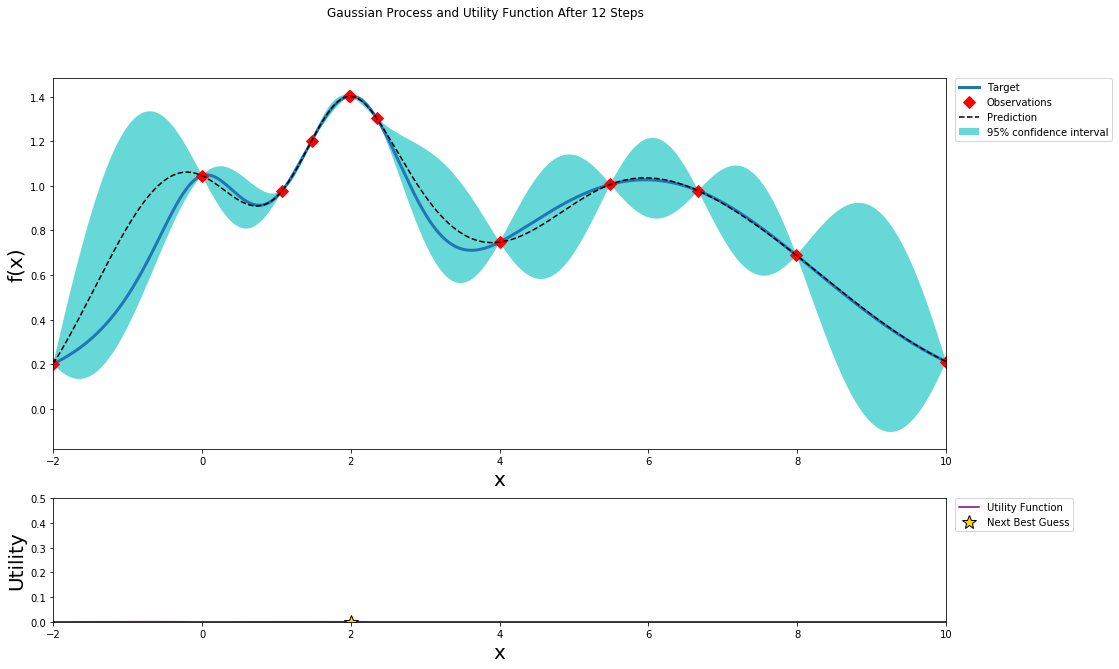

In [11]:
plot_gp(bo.gp, x, y, bo.util)

## Our implementation

In [14]:
candidates = []
for i in range(n_iter):
    candidate = bayesian_optimizer.get_candidate(X_train, Y_train, [(-2, 10)], acq=acq, xi=xi, **gp_params)
    X_train = np.vstack((X_train, np.array([candidate])))
    Y_train = np.hstack((Y_train, target(candidate)))
    candidates.append(candidate)
candidates

[2017-07-27 14:23:24,456] [bayesian_optimizer:178] [DEBUG]
Fitting Gaussian Processor Regressor: GaussianProcessRegressor(alpha=1e-05, copy_X_train=True,
             kernel=Matern(length_scale=1, nu=2.5),
             n_restarts_optimizer=25, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=6)
[2017-07-27 14:23:24,544] [bayesian_optimizer:182] [DEBUG]
Computing argmax of acquisition function
[2017-07-27 14:23:25,476] [bayesian_optimizer:178] [DEBUG]
Fitting Gaussian Processor Regressor: GaussianProcessRegressor(alpha=1e-05, copy_X_train=True,
             kernel=Matern(length_scale=1, nu=2.5),
             n_restarts_optimizer=25, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=6)
[2017-07-27 14:23:25,539] [bayesian_optimizer:182] [DEBUG]
Computing argmax of acquisition function
[2017-07-27 14:23:26,781] [bayesian_optimizer:178] [DEBUG]
Fitting Gaussian Processor Regressor: GaussianProcessRegressor(alpha=1e-05, copy_X_train=True,
        

[array([ 10.]),
 array([ 1.074381]),
 array([ 2.34706327]),
 array([ 1.9938764]),
 array([ 6.67000175]),
 array([ 7.98884194]),
 array([ 5.48966169]),
 array([ 1.97742281]),
 array([ 2.00568539]),
 array([-0.77805103])]

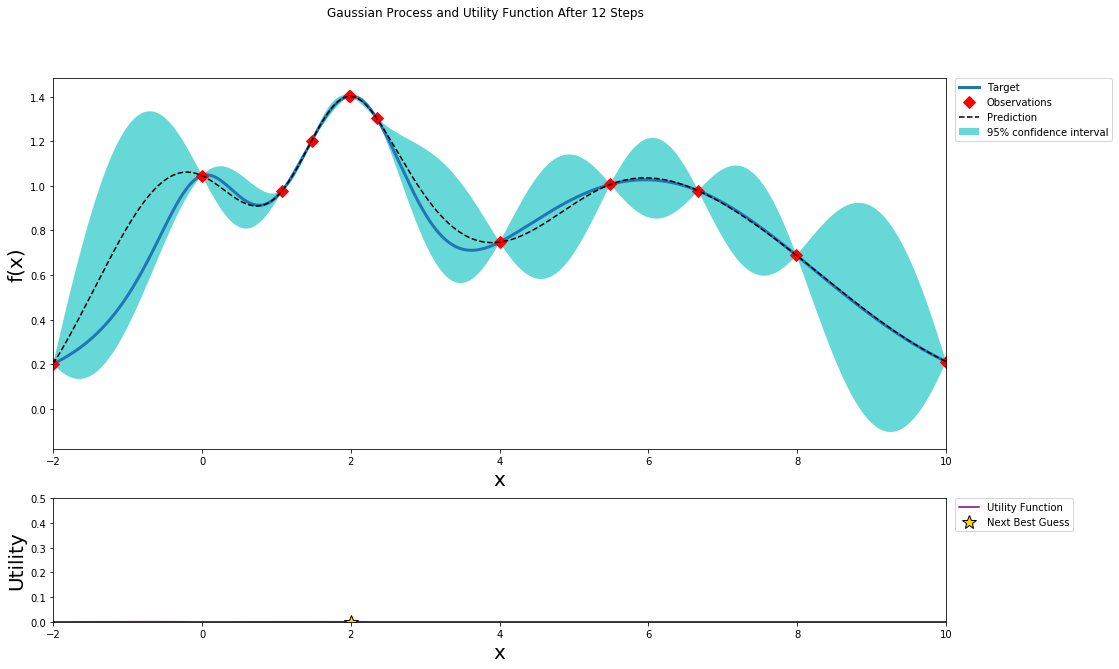

In [15]:
gp = GaussianProcessRegressor()
gp.set_params(**gp_params)
gp.fit(X_train, Y_train)


util = bayesian_optimizer.UtilityFunction(kind=acq, xi=xi)
plot_gp(bo.gp, x, y, bo.util)